**This notebook shows the latent space interpolation of the generated Mi Fu style images. The method is the same for the generated Liu Gongquan style images.**

Import libraries

In [1]:
from math import log2
import random
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import shutil
import pandas as pd

In [2]:
def show_tensor_images(image_tensor, num_images=10, nrow=5, figsize=(7,7)):
    image_clipped = torch.clamp(image_tensor, min=-1.0, max=1.0)
    image_shifted = (image_clipped + 1) / 2
    image_grid = make_grid(image_shifted[:num_images].detach().cpu(), nrow=nrow)
    plt.figure(figsize = figsize)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
DEVICE                  = "cuda"
image_size              = 64
CHANNELS_IMG            = 3
Z_DIM                   = 512
IN_CHANNELS             = 512

In [4]:
class ELConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ELConv2d, self).__init__()
        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(out_channels))
        self.stride = stride
        self.padding = padding
        self.fan_in = in_channels * kernel_size * kernel_size
        self.scale = (2 / self.fan_in) ** (0.5)

        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return F.conv2d(input=x,
                        weight=self.weight * self.scale,
                        bias=self.bias,
                        stride=self.stride,
                        padding=self.padding)

class ELConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=1, padding=0):
        super(ELConvTranspose2d, self).__init__()
        self.weight = nn.Parameter(torch.zeros(in_channels, out_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.zeros(out_channels))
        self.stride = stride
        self.padding = padding
        self.fan_in = in_channels
        self.scale = (2 / self.fan_in) ** (0.5)

        nn.init.normal_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return F.conv_transpose2d(input=x,
                                  weight=self.weight * self.scale,
                                  bias=self.bias,
                                  stride=self.stride,
                                  padding=self.padding)

class ELLinear(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ELLinear, self).__init__()
        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels))
        self.bias = nn.Parameter(torch.zeros(out_channels))
        self.fan_in = in_channels
        self.scale = (2 / self.fan_in) ** (0.5)

    def forward(self, x):
        return F.linear(input=x,
                        weight=self.weight * self.scale,
                        bias=self.bias)

class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

class MiniBatchSTD(nn.Module):
    def __init__(self):
        super(MiniBatchSTD, self).__init__()
        self.alpha = 1e-8

    def forward(self, x):
        batch_size, _, height, width = x.shape
        y = x - x.mean(dim=0, keepdim=True)
        y = torch.sqrt(y.pow(2).mean(dim=0, keepdim=False) + self.alpha)
        y = y.mean()
        y = y.repeat(batch_size, 1, height, width)
        y = torch.cat([x, y], 1)
        return y

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = ELConv2d(in_channels, out_channels)
        self.conv2 = ELConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        self.initial_block = nn.Sequential(
            PixelNorm(),
            ELLinear(z_dim, in_channels * 4 * 4),
            nn.Unflatten(1, (in_channels, 4, 4)),
            nn.LeakyReLU(0.2),
            PixelNorm(),
            ELConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )  # 4

        self.prog_blocks = nn.ModuleList([
            ConvBlock(in_channels, in_channels),              # 8
            ConvBlock(in_channels, in_channels),              # 16
            ConvBlock(in_channels, in_channels),              # 32
            ConvBlock(in_channels, in_channels // 2),         # 64
        ])

        self.to_rgb_layers = nn.ModuleList([
            ELConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0),        # 4
            ELConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0),        # 8
            ELConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0),        # 16
            ELConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0),        # 32
            ELConv2d(in_channels // 2, img_channels, kernel_size=1, stride=1, padding=0),   # 64
        ])

    def forward(self, x, alpha, steps):
        assert alpha >= 0 and alpha <= 1, "Value of alpha out of range"

        out = self.initial_block(x)

        if steps == 0:
            return self.to_rgb_layers[0](out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        if alpha < 1:
            final_upscaled = self.to_rgb_layers[steps - 1](upscaled)
            final_out = self.to_rgb_layers[steps](out)
            return alpha * final_out + (1 - alpha) * final_upscaled
        else:
            final_out = self.to_rgb_layers[steps](out)
            return final_out

In [6]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load pretrained weights stored in my personal google drive

In [9]:
gen_ema = Generator(Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)

loaded_state = torch.load('drive/MyDrive/Caligraphy/Mi_Fu_style_weights.pt')
gen_ema.load_state_dict(loaded_state["gen_ema"]);

In [10]:
gen_ema.eval();

Load selected noises stored in my personal google drive

In [11]:
x = torch.load('drive/MyDrive/Caligraphy/Mi_Fu_style_selected_noises.pt')

In [12]:
noise1 = x[4,:].view(1, Z_DIM)
noise2 = x[8,:].view(1, Z_DIM)
noise3 = x[13,:].view(1, Z_DIM)
noise4 = x[21,:].view(1, Z_DIM)

In [13]:
with torch.no_grad():
    g1 = ((torch.clamp(gen_ema(noise1, 1.0, 4), min=-1.0, max=1.0)+1)/2).squeeze().permute(1,2,0).detach().to('cpu')
    g2 = ((torch.clamp(gen_ema(noise2, 1.0, 4), min=-1.0, max=1.0)+1)/2).squeeze().permute(1,2,0).detach().to('cpu')
    g3 = ((torch.clamp(gen_ema(noise3, 1.0, 4), min=-1.0, max=1.0)+1)/2).squeeze().permute(1,2,0).detach().to('cpu')
    g4 = ((torch.clamp(gen_ema(noise4, 1.0, 4), min=-1.0, max=1.0)+1)/2).squeeze().permute(1,2,0).detach().to('cpu')

Images to be used for interpolation


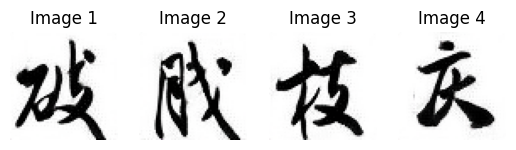

In [14]:
print("Images to be used for interpolation")
fig, ax = plt.subplots(1,4)
ax[0].imshow(g1)
ax[0].title.set_text('Image 1')
ax[0].axis('off')
ax[1].imshow(g2)
ax[1].title.set_text('Image 2')
ax[1].axis('off')
ax[2].imshow(g3)
ax[2].title.set_text('Image 3')
ax[2].axis('off')
ax[3].imshow(g4)
ax[3].title.set_text('Image 4')
ax[3].axis('off')
plt.show()

In [15]:
weights = torch.linspace(0, 1, steps=100).to(DEVICE)

Spherical linear interpolation

In [16]:
def slerp(start, end, weight):
    start_norm = start/torch.linalg.norm(start)
    end_norm = end/torch.linalg.norm(end)
    omega = torch.acos(torch.sum((start_norm*end_norm)))
    result = (torch.sin((1.0-weight)*omega)/torch.sin(omega)) * start + (torch.sin(weight*omega)/torch.sin(omega)) * end
    return result

In [17]:
imgs_1 = []
imgs_2 = []
imgs_3 = []
imgs_4 = []

In [18]:
if not os.path.exists('Interpolation'):
    os.makedirs('Interpolation')

In [19]:
for i in range(100):
    interpolated_g1 = slerp(noise1, noise2, weights[i]).to(DEVICE)
    interpolated_g2 = slerp(noise2, noise3, weights[i]).to(DEVICE)
    interpolated_g3 = slerp(noise3, noise4, weights[i]).to(DEVICE)
    interpolated_g4 = slerp(noise4, noise1, weights[i]).to(DEVICE)
    with torch.no_grad():
        img_g1 = gen_ema(interpolated_g1, 1.0, 4)
        img_g1 = torch.clamp(img_g1, min=-1.0, max=1.0)
        img_g2 = gen_ema(interpolated_g2, 1.0, 4)
        img_g2 = torch.clamp(img_g2, min=-1.0, max=1.0)
        img_g3 = gen_ema(interpolated_g3, 1.0, 4)
        img_g3 = torch.clamp(img_g3, min=-1.0, max=1.0)
        img_g4 = gen_ema(interpolated_g4, 1.0, 4)
        img_g4 = torch.clamp(img_g4, min=-1.0, max=1.0)
        row1 = torch.cat([img_g1, img_g2], dim=-1)
        row2 = torch.cat([img_g3, img_g4], dim=-1)
        img_grid = torch.cat([row1, row2], dim=2)
        imgs_1.append(img_grid)
        if i < 10:
            name = '1_' + '0' + str(i)
        else:
            name = '1_' + str(i)
        save_image(img_grid*0.5+0.5, f"Interpolation/img_{name}.png")

In [20]:
for i in range(100):
    interpolated_g1 = slerp(noise2, noise3, weights[i]).to(DEVICE)
    interpolated_g2 = slerp(noise3, noise4, weights[i]).to(DEVICE)
    interpolated_g3 = slerp(noise4, noise1, weights[i]).to(DEVICE)
    interpolated_g4 = slerp(noise1, noise2, weights[i]).to(DEVICE)
    with torch.no_grad():
        img_g1 = gen_ema(interpolated_g1, 1.0, 4)
        img_g1 = torch.clamp(img_g1, min=-1.0, max=1.0)
        img_g2 = gen_ema(interpolated_g2, 1.0, 4)
        img_g2 = torch.clamp(img_g2, min=-1.0, max=1.0)
        img_g3 = gen_ema(interpolated_g3, 1.0, 4)
        img_g3 = torch.clamp(img_g3, min=-1.0, max=1.0)
        img_g4 = gen_ema(interpolated_g4, 1.0, 4)
        img_g4 = torch.clamp(img_g4, min=-1.0, max=1.0)
        row1 = torch.cat([img_g1, img_g2], dim=-1)
        row2 = torch.cat([img_g3, img_g4], dim=-1)
        img_grid = torch.cat([row1, row2], dim=2)
        imgs_2.append(img_grid)
        if i < 10:
            name = '2_' + '0' + str(i)
        else:
            name = '2_' + str(i)
        save_image(img_grid*0.5+0.5, f"Interpolation/img_{name}.png")

In [21]:
for i in range(100):
    interpolated_g1 = slerp(noise3, noise4, weights[i]).to(DEVICE)
    interpolated_g2 = slerp(noise4, noise1, weights[i]).to(DEVICE)
    interpolated_g3 = slerp(noise1, noise2, weights[i]).to(DEVICE)
    interpolated_g4 = slerp(noise2, noise3, weights[i]).to(DEVICE)
    with torch.no_grad():
        img_g1 = gen_ema(interpolated_g1, 1.0, 4)
        img_g1 = torch.clamp(img_g1, min=-1.0, max=1.0)
        img_g2 = gen_ema(interpolated_g2, 1.0, 4)
        img_g2 = torch.clamp(img_g2, min=-1.0, max=1.0)
        img_g3 = gen_ema(interpolated_g3, 1.0, 4)
        img_g3 = torch.clamp(img_g3, min=-1.0, max=1.0)
        img_g4 = gen_ema(interpolated_g4, 1.0, 4)
        img_g4 = torch.clamp(img_g4, min=-1.0, max=1.0)
        row1 = torch.cat([img_g1, img_g2], dim=-1)
        row2 = torch.cat([img_g3, img_g4], dim=-1)
        img_grid = torch.cat([row1, row2], dim=2)
        imgs_3.append(img_grid)
        if i < 10:
            name = '3_' + '0' + str(i)
        else:
            name = '3_' + str(i)
        save_image(img_grid*0.5+0.5, f"Interpolation/img_{name}.png")

In [22]:
for i in range(100):
    interpolated_g1 = slerp(noise4, noise1, weights[i]).to(DEVICE)
    interpolated_g2 = slerp(noise1, noise2, weights[i]).to(DEVICE)
    interpolated_g3 = slerp(noise2, noise3, weights[i]).to(DEVICE)
    interpolated_g4 = slerp(noise3, noise4, weights[i]).to(DEVICE)
    with torch.no_grad():
        img_g1 = gen_ema(interpolated_g1, 1.0, 4)
        img_g1 = torch.clamp(img_g1, min=-1.0, max=1.0)
        img_g2 = gen_ema(interpolated_g2, 1.0, 4)
        img_g2 = torch.clamp(img_g2, min=-1.0, max=1.0)
        img_g3 = gen_ema(interpolated_g3, 1.0, 4)
        img_g3 = torch.clamp(img_g3, min=-1.0, max=1.0)
        img_g4 = gen_ema(interpolated_g4, 1.0, 4)
        img_g4 = torch.clamp(img_g4, min=-1.0, max=1.0)
        row1 = torch.cat([img_g1, img_g2], dim=-1)
        row2 = torch.cat([img_g3, img_g4], dim=-1)
        img_grid = torch.cat([row1, row2], dim=2)
        imgs_4.append(img_grid)
        if i < 10:
            name = '4_' + '0' + str(i)
        else:
            name = '4_' + str(i)
        save_image(img_grid*0.5+0.5, f"Interpolation/img_{name}.png")

In [23]:
tensor_imgs_1 = torch.cat([x for x in imgs_1], dim=0)
tensor_imgs_2 = torch.cat([x for x in imgs_2], dim=0)
tensor_imgs_3 = torch.cat([x for x in imgs_3], dim=0)
tensor_imgs_4 = torch.cat([x for x in imgs_4], dim=0)

In [24]:
sel_tensor_imgs_1 = torch.stack([tensor_imgs_1[i,:,:,:] for i in range(len(tensor_imgs_1)) if i % 11 == 0], dim=0)

In [25]:
sel_tensor_imgs_2 = torch.stack([tensor_imgs_2[i,:,:,:] for i in range(len(tensor_imgs_2)) if i % 11 == 0], dim=0)

In [26]:
sel_tensor_imgs_3 = torch.stack([tensor_imgs_3[i,:,:,:] for i in range(len(tensor_imgs_3)) if i % 11 == 0], dim=0)

In [27]:
sel_tensor_imgs_4 = torch.stack([tensor_imgs_4[i,:,:,:] for i in range(len(tensor_imgs_3)) if i % 11 == 0], dim=0)

Step1 -> Step2

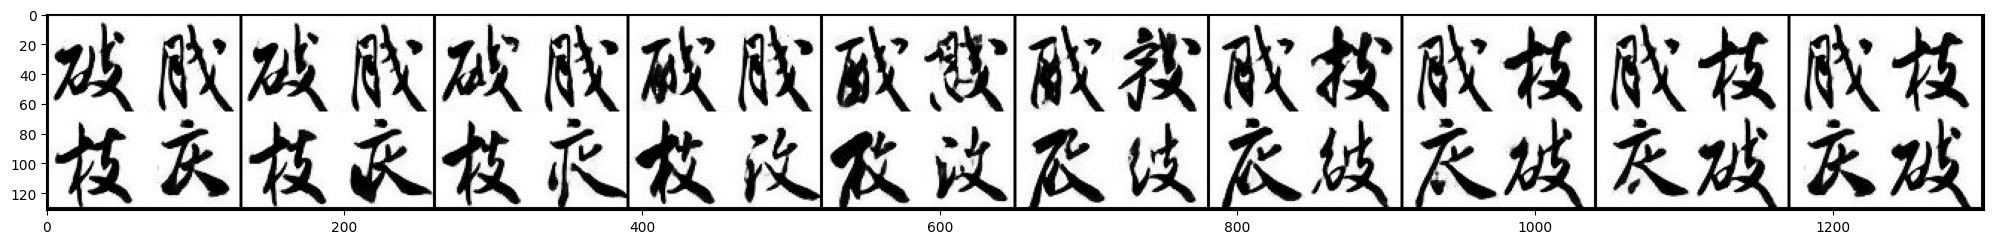

In [28]:
show_tensor_images(sel_tensor_imgs_1, num_images=10, nrow=10, figsize=(25,25))

Step2 -> Step3

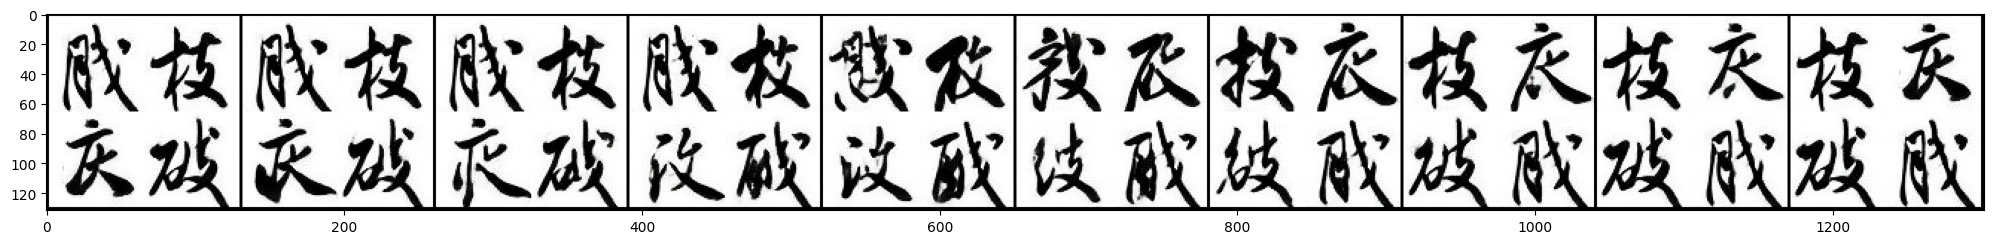

In [29]:
show_tensor_images(sel_tensor_imgs_2, num_images=10, nrow=10, figsize=(25,25))

Step3 -> Step4

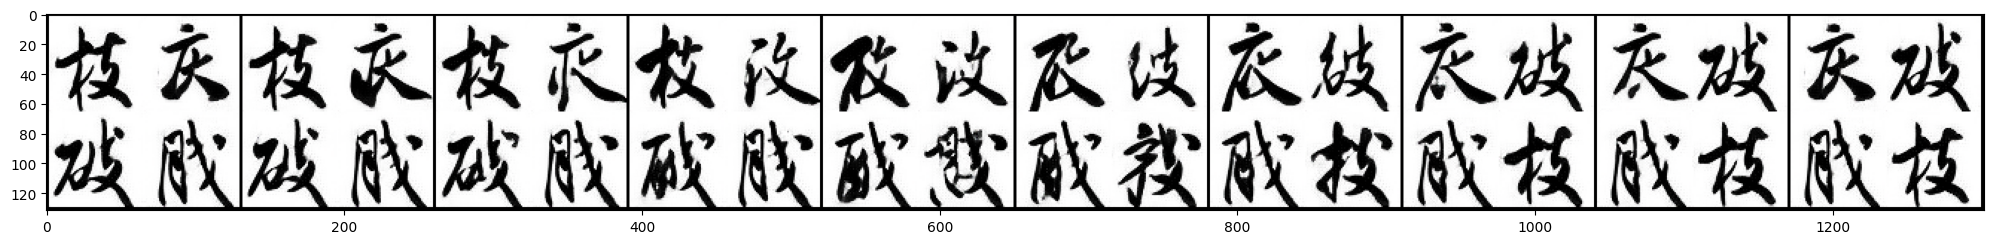

In [30]:
show_tensor_images(sel_tensor_imgs_3, num_images=10, nrow=10, figsize=(25,25))

Step4 -> Step1

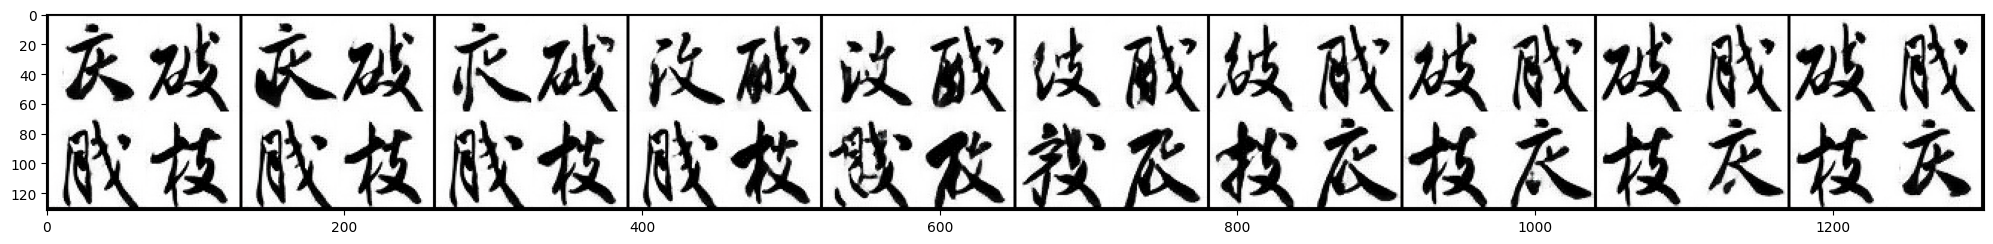

In [31]:
show_tensor_images(sel_tensor_imgs_4, num_images=10, nrow=10, figsize=(25,25))

In [32]:
img_names = sorted(os.listdir('Interpolation'))

In [33]:
from IPython import display
from PIL import Image
import imageio.v2 as imageio

In [34]:
images = []

In [35]:
for image_name in img_names:
    if image_name.startswith('img_1'):
        images.append(imageio.imread(os.path.join('Interpolation', image_name)))

In [36]:
for _ in range(45):
    images.append(imageio.imread(os.path.join('Interpolation', 'img_1_99.png')))

In [37]:
for image_name in img_names:
    if image_name.startswith('img_2'):
        images.append(imageio.imread(os.path.join('Interpolation', image_name)))

In [38]:
for _ in range(45):
    images.append(imageio.imread(os.path.join('Interpolation', 'img_2_99.png')))

In [39]:
for image_name in img_names:
    if image_name.startswith('img_3'):
        images.append(imageio.imread(os.path.join('Interpolation', image_name)))

In [40]:
for _ in range(45):
    images.append(imageio.imread(os.path.join('Interpolation', 'img_3_99.png')))

In [41]:
for image_name in img_names:
    if image_name.startswith('img_4'):
        images.append(imageio.imread(os.path.join('Interpolation', image_name)))

In [42]:
for _ in range(45):
    images.append(imageio.imread(os.path.join('Interpolation', 'img_4_99.png')))

Save and display the generated .gif image

In [43]:
imageio.mimsave('Mi_Fu_style_interpolation.gif', images, loop=0, duration=30)

Interpolation of the generated Mi Fu style images


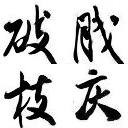

In [45]:
from IPython import display
print("Interpolation of the generated Mi Fu style images")
display.Image(open('Mi_Fu_style_interpolation.gif', 'rb').read())